# Project 01 - Strong Lensing Simulations with Lenstronomy

## INTRODUCTION

Strong lenses is a phenomenon that occurs when the light of a distant galaxy suffers a distortion when passing by a massive object (such as another galaxy or a galaxy cluster). These systems are exceptionally interesting because of the magnification effect, which allows us to observe objects that are even farther in the universe. Nevertheless, the study of such objects can be extremely expensive, due to the amount of time required in the large telescopes for the observation of it. Alternatively, the study of a synthetic population is extensively cheaper and it can  assist us in the understanding of observed systems. 

In this work I intend to create a simulated sample of strong lenses using the deeplenstronomy library in python. Additionally, in order to assure that these computationally created systems can exist in the real universe, I shall compare it to an observed sample of strong lensing. 


## Can we create a simulated sample that look real?

- Strong Lens systems are “rare”

- Observation are expensive

- Real samples take time


## Strong Lensing?

<img src="images/lensing.jpg" alt="SL" width="800"/>

Image from ALMA (ESO/NRAO/NAOJ). But there also a really cool video from [HubbleESA](https://www.youtube.com/watch?v=Rsx0AGQhQvs)


## The DES survey simulated sample

In [1]:
#As always let's start by the libraries
import deeplenstronomy.deeplenstronomy as dl
from deeplenstronomy.visualize import view_image, view_image_rgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from scipy import stats as st
from scipy.optimize import curve_fit
from random import sample

In [2]:
#And then reading the dess data

#Lens population discoverable in the DES_optimal_coadd
#
#The population was forecast by T.Collett (ICG, Portsmouth) - please cite Collett (2015)
#
#Each line in the table represents a single lens. Table contains full mock lens catalog.
#The columns in the table are:
#------------------------------------
#[0] image index
#[1] zl, lens redshift
#[2] zs, source redshift
#[3] thetaE, Einstein radius (arcseconds)
#[4] sig_v, lens velocity dispersion (km/s)
#[5] ql, lens flattening (1=circular, q=1-e)
#[6] rl, lens half light radius (arcseconds) NB/ sersic index is 4
#[7] lens g band magnitude
#[8] lens r band magnitude
#[9] lens i band magnitude
#[10] DUPLICATE of [6]
#[11] xs, source x coordinate relative, 0 is lens centre (arcseconds)
#[12] ys, source y coordinate relative, 0 is lens centre (arcseconds)
#[13] qs, source flattening (1=circular, q=1-e)
#[14] ps, source position angle (degrees)
#[15] rs, source half light radius (arcseconds) NB/ sersic index is 1
#[16] mu_s, source magnification
#[17] g band coadd seeing
#[18] g band coadd signal-to-noise of source assuming poisson limited lens subtraction
#[19] r band coadd seeing
#[20] r band coadd signal-to-noise of source assuming poisson limited lens subtraction
#[21] i band coadd seeing
#[22] i band coadd signal-to-noise of source assuming poisson limited lens subtraction
#[23] signal-to-noise in the g - i difference image
#------------------------------------
des = pd.read_csv('data/lenses_DESc.txt', sep=" ", header=None, skiprows = 34 )
des.columns = ["index", "zl", "zs", "thetaE", "sig_v", "ql", "rl", 
                "lens_g", "lens_r", "lens_i", "rl2",          
                "xs", "ys", "qs", "ps",
               "rs", "mu_s", "seein_g", 
               "seein_g_im","seein_r", "seein_r_im","seein_i", "seein_i_im", "g-i"]
#print(des)

### About reproducing "real" data

This data set has 23 columns that caracterise 18598 strong lens systems. The deeplenstronomy would allow me to reproduce most of then, but I can't do it because it means a lot of iterations which leads to a huge computational cost. So I will keep it simple and focuse in a simple lens' observables: the magnitudes at the g, r and i band. Besides I shall relate it to the lens redshift.

so let's start by taking a look into the real data set


<function matplotlib.pyplot.show(close=None, block=None)>

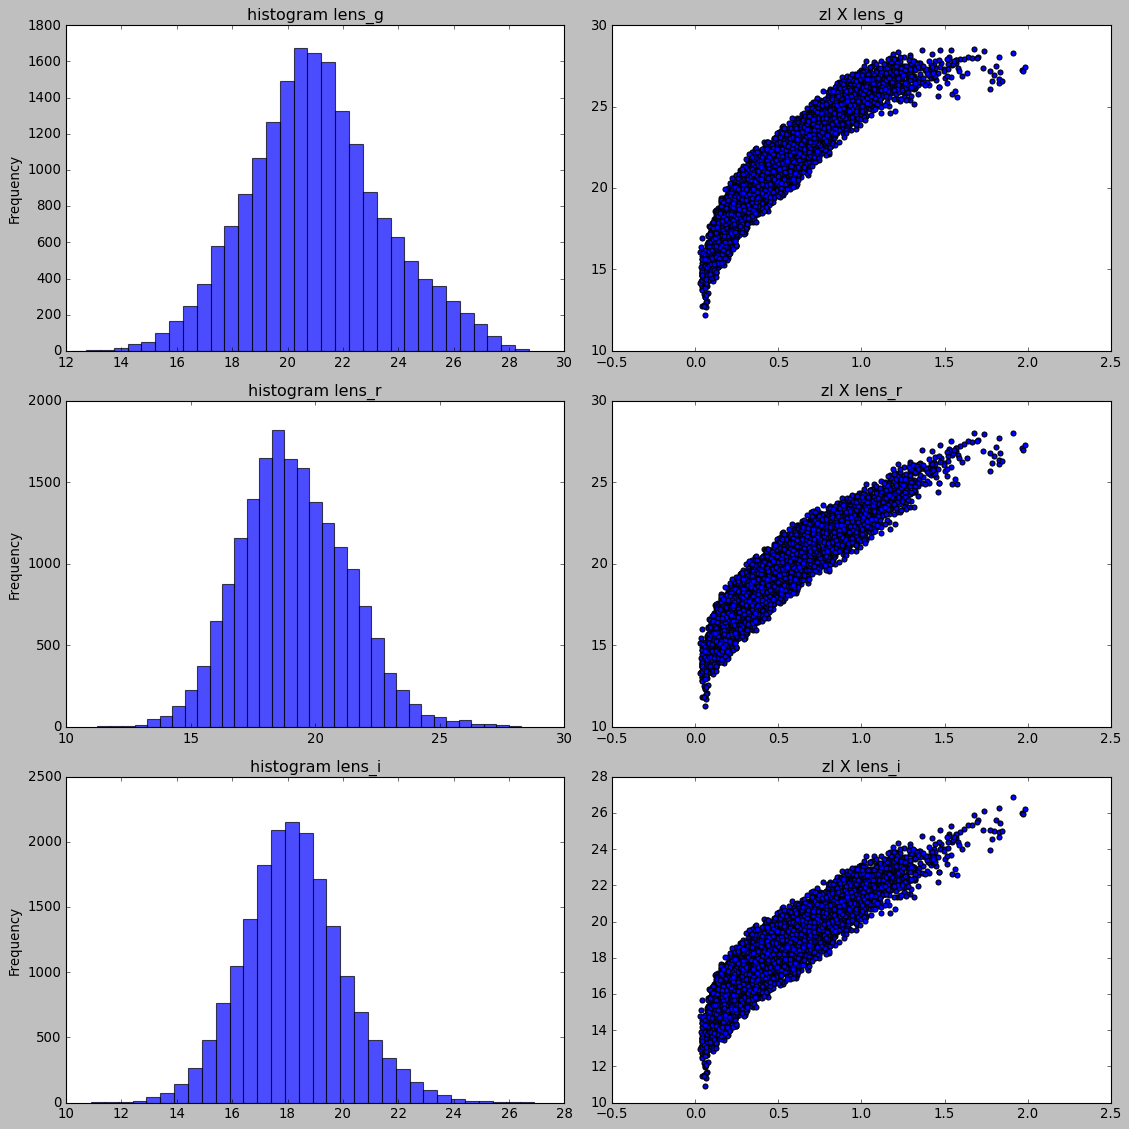

In [3]:
#histogran
key_list =  ["lens_g", "lens_r", "lens_i"]
hor = 2
ver = 3

plt.style.use('classic')

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)

binsize=0.5
def binarange(arr, binsize):
    return np.arange(np.nanmin(arr), np.nanmax(arr)+binsize, binsize)


for v in range(ver):
    ax = fig.add_subplot(gs[v, 0])
    bins = binarange(des[key_list[v]], binsize)
    ax = des[key_list[v]].plot.hist(bins=bins,  alpha=0.7)
    ax.set_title("histogram " + key_list[v])
    
    ax = fig.add_subplot(gs[v, 1])
    ax.scatter(x = des["zl"], y = des[key_list[v]])
    ax.set_title("zl X " + key_list[v])
    

plt.show

### some considerations

Above the plot that I want to reproduce with the deeplenstronomy. 

We can see by the plots from the right side that chose the lens' redshif to relate the mag is reasonable once there is a clear correlation between these quantites. This is no surprise once the magnitude is proportional to the distance's logarithm, and it is pretty safe to state that in the strong lens context, redshift is distance, once as farther is the object from us, higher is its redshift.

## The Deeplentronomy

The deeplenstronomy is a module created in python for the simulation of strong lens datasets. One can find more informations [here](https://pypi.org/project/deeplenstronomy/) and [here](https://github.com/deepskies/deeplenstronomy).

In addition to that this project was based in the Deeplentronomy full example that can be found [here](https://deepskies.github.io/deeplenstronomy/Notebooks/FullExample.html)

### Before we start

we have to set the system configuration. I have faced some problens due the version of some puython libraries. So mabe it will be coutious to create a python enviroment with the follow specifications

> wheel = 0.22
>
> scipy = 1.5.2
>
> pandas = 1.1.2
> 
> numpy = 1.19.1
>
> matplotlib = 3.3.2
>
> astropy = 4.0.1.post1
>
> h5py = 2.10.0
>
> pyyaml = 5.3.1
>
> mpmath = 1.1.0
>
> future = 0.18.2
>
>lenstronomy = 1.6.0

and install the deeplens version 0.0.2.0 with the command

> `pip install git+https://github.com/deepskies/deeplenstronomy.git@v0.0.2.0`


### Before the python

Most of the deeplenstronomy magic ocours at the configuration file (configuration_file.yaml). It will be defined in 5 section: "DATASET", "COSMOLOGY", "SPECIES", "DISTRIBUTIONS" and "GEOMETRY".

The **DATASET** section looks like this:

<img src="images/dataset.png" alt="SL" width="600"/>

and it shall contain the basic information of the dataset, as for example the directory where it will be saved and the size of the DS, in this example I will generate 1000 SL systems


The **COSMOLOGY** section looks like this:

<img src="images/cosmology.png" alt="SL" width="200"/>
here we are going to use the standart cosmological model, but we need to define it here.

The **SPECIES** section is where we define the objects in our data set. It can have as many objects as you wish. But because the data set that I will create will be a galaxy-galaxy lens system, we will only need a galaxy to be our lens and a galaxy to be the source. It show be like this:

<img src="images/species.png" alt="SL" width="700"/>

The **DISTRIBUTIONS** section is where we indicate the path for files with the distributions that we may wnat to use in our data set, I will talk more abot how to gerate these files later 

<img src="images/distributions.png" alt="SL" width="400"/>

Finally the **GEOMETRY** section 
<img src="images/geometry.png" alt="SL" width="500"/>

here we divide the final images in planes, the separation of the planes will be given by the redshift. You can define as many geometry as you want, with as many planes as you wish, but here I may keep it simple and define one geometry witha plane for the lens and one plane for the source.

### Creating distributions

If we want a create a data set that looks real, it is a good idea to use real data in the simulated data backgroung. In other words we can sample our parameters from the des data.

To begin with, because we are going to use the lens' redshift, it is important to ensure that the lens z is ALWAYS smaler than the source z. So let's look into the des data do see what it says about it:

Text(0.5, 1.0, 'zs des')

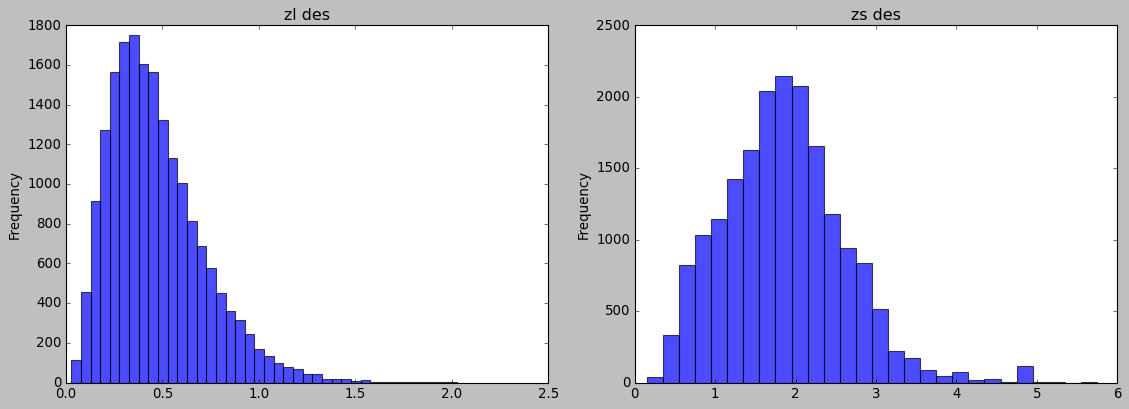

In [4]:
fig = plt.figure(figsize=(14, 5), constrained_layout=True)
gs = fig.add_gridspec(1, 2, left=0.05, right=0.5, wspace=0.05)

ax = fig.add_subplot(gs[0, 0])
bins = binarange(des["zl"], 0.05)
ax = des["zl"].plot.hist(bins=bins,  alpha=0.7)
#ax = plt.scatter(x_new,y, color = "black")
ax.set_title("zl des")

ax = fig.add_subplot(gs[0, 1])
bins = binarange(des["zs"], 0.2)
ax = des["zs"].plot.hist(bins=bins,  alpha=0.7)
ax.set_title("zs des")

So, here we have a problem, when we talk about randon sample we can get really unluck to get a zl higher than 1 and a zs smaler than 1, and this can couse a big problem. Besides that, there is no clear correlation between zl and zs as we can see in

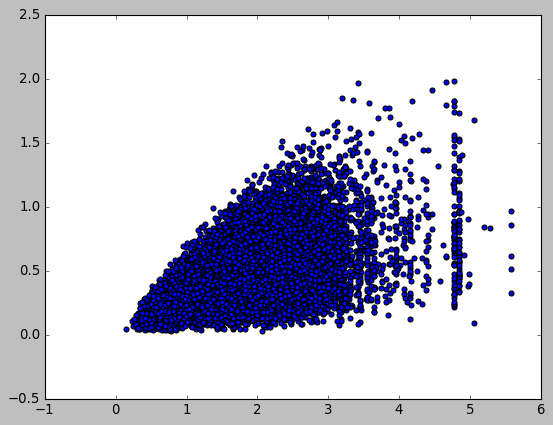

In [5]:
plt.scatter(x = des["zs"], y = des["zl"])
plt.show()

That will make really dificult to define a distribution that can reproduce this situation. The deeplens full example sugest to define a uniform distribution that will create a maximun and minimum limit in these variables. but we can see by the last histograms that its cleary do not behave like this. This is not really a problem for the souece redshift, because we do not really care with how it will looklike, but this will defnitelly be a problem for the lens redshift.

So let take a deeper look into the zl data, starting by cut it in 1. Defining zl < 1 won't be a big loss: 

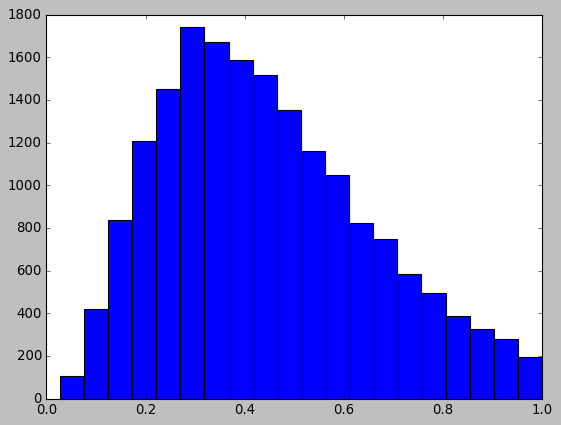

In [6]:
y, x, _ = plt.hist(des[(des["zl"] < 1)]["zl"], bins = 20)

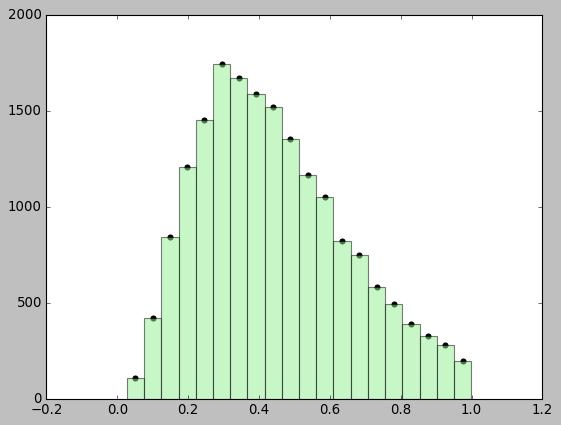

In [7]:
#now lets get the central point at each bin
x_new = []
for i in range (20):
    x_new.append((x[i] + x[i + 1])/2.0)
plt.hist(des[(des["zl"] < 1)]["zl"], bins = 20, color="lightgreen", alpha = 0.5)
plt.scatter(x_new,y, color = "black")

We can try fit this in a lognorm distribution. It is given by 

$$f(x,s) = \frac{1}{sx\sqrt{2\pi}}\exp\left (-\frac{\log^2(x) - \mu}{2s^2}  \right )$$

and you can have more information in the  [lognorm wikipedia page](https://en.wikipedia.org/wiki/Log-normal_distribution) and in the [lognorm scipy page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html)

so let's fit it in our data:

In [8]:
s, loc, scale = st.lognorm.fit(list(des[(des["zl"] < 1)]["zl"]), floc=0) 
mu = np.log(scale)
 
print(mu, s,loc, scale)

-0.9409814218168051 0.5323481876172378 0.0 0.3902446527412955


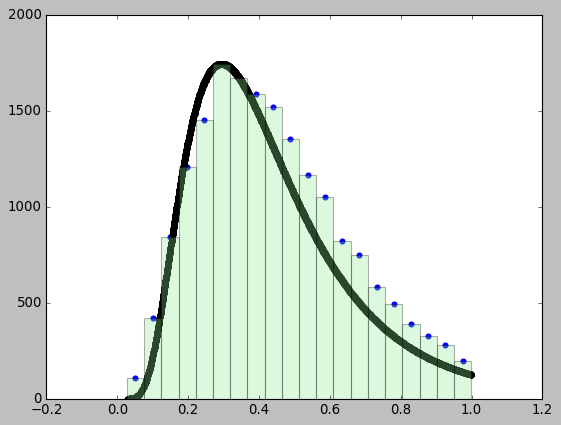

In [9]:
y_dist = st.lognorm.pdf(list(des[(des["zl"] < 1)]["zl"]), s, loc, scale)
plt.hist(des[(des["zl"] < 1)]["zl"], bins = 20, color="lightgreen", alpha = 0.3)
plt.scatter(x_new,y, color = "blue")
plt.scatter(list(des[(des["zl"] < 1)]["zl"]), y_dist/(y_dist.max()/y.max()), color = "black")

Finally we can see that the zl data is way more messy than the continuous lognorm distribution. But my main objective with all of this is to favour the zl values that ar close to the peak of the distribution and at the same time assure that it keep away from 1. So in the end this will serve to its purpose.


But, yet, this PDF is define to the infinity, and I can get unlucky and the program will chose a value higher than 1 with really low probability. So I am goin to use this PDF as weight, and ask to the code select randomly from a predifined set of values. 


**And here we start to talk about how define the distribution files from the distribution section.** Remember when we were talking bout the sections in the configuration files? so now we going to start to construct then.

The first thing that you need to know about the configuration files is that it is a .txt and the first row will be the name of the parameter (or parameters) you and to sample and the the weight, it don't need to be normalized, once the deeplens will do itself.

For define the zl distribution we goin to have **PLANE_1-OBJECT_1-REDSHIFT**, since the plane 1 in the geometry is the lens plane, this collumn will have the DES values for zl that are smaller than 1, and then the **WEIGHT** value gived by the PDF defined above.

In [10]:
#PLANE_1-OBJECT_1-REDSHIFT
file = open("data/lens_redshifts.txt", "w")
zl = list(des["zl"][des["zl"] < 1])
file.write("PLANE_1-OBJECT_1-REDSHIFT WEIGHT\n")

for i in range(len(zl)):
    file.write(str(zl[i]))
    file.write(" ")
    file.write(str(y_dist[i]))
    file.write("\n")
file.close()

**Now that we are sure that the redshifts won cause any problem we can work in our main objetive: the magnitudes.**

Again we are sampling then from the DES data. This time, because we are linking it to the redshifht we don't need define a weight, so we will let it be one for every line.

Some regards: firstly in this data set we have data of 3 bands (g, r, i), but, if we are going to define then separatelly, the deeplens expect that we define 5 bands (those 3 plus z and Y). That is not a big concern since it will only be important to visualise the images, and not to comparison with real data, so I will sample this values from a normal distribution centred aroun 20, since it is kind of a patern for magnitudes. 

Secondly I will use half the mags data, to see if a I can get some distribution close to the real ones if I don have all the systems.

In [11]:
index = sample(list(range(0, des.shape[0])), round(np.float(des.shape[0])/2))

file = open("data/mags_lens.txt", "w")
mags = ["zl", "lens_g", "lens_r", "lens_i"]
file.write("CONFIGURATION_1-PLANE_1-OBJECT_1-REDSHIFT CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-r CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-i CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-z CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-Y WEIGHT\n")
for i in index:
    if des["zl"][i] < 1:
        for m in mags:
            file.write(str(round(des[m][i],8)))
            file.write(" ")
            
        mag_z = np.random.normal(loc=19.5, scale=1.0)
        mag_Y = np.random.normal(loc=21, scale=1.0)
        file.write(str(round(mag_z,8)))
        file.write(" ")
        file.write(str(round(mag_Y,8))) 
        file.write(" ")
        file.write("1.0")
        file.write("\n")
file.close() 

### Let's simulate

In [20]:
deeplens = dl.make_dataset('data/configuration_file.yaml', survey='des', verbose=True)

Entering main organization loop
Organizing CONFIGURATION_1
Generating images for CONFIGURATION_1
	Progress: 100.0 %  ---  Elapsed Time: 0 H 0 M 48 S         


The ``deeplens`` object has two main dictionaries. the ``deeplens.CONFIGURATION_1_images`` contain the fit information to plot the lens images and the ``deeplens.CONFIGURATION_1_metadata`` that is a data frame  with the systems data.

For the images we can plot each band separatelly:

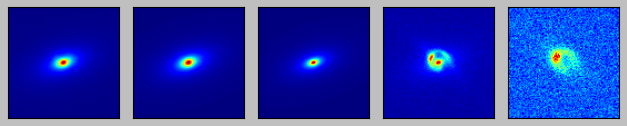

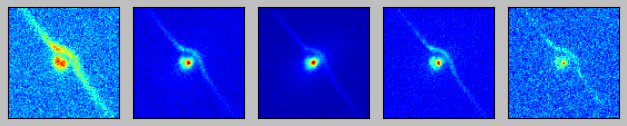

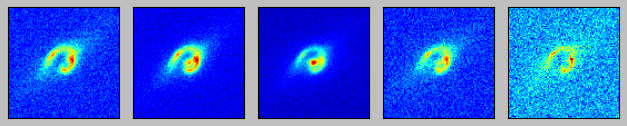

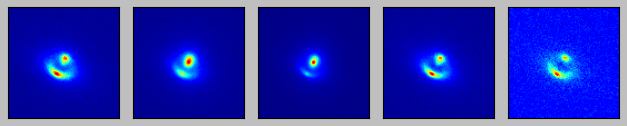

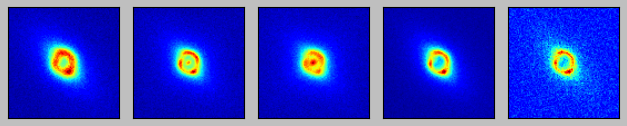

In [21]:
for i in range(5):
    view_image(deeplens.CONFIGURATION_1_images[i])

or stack then to create a RGB image:

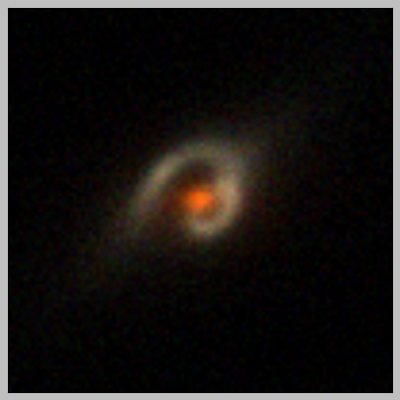

In [25]:
view_image_rgb(deeplens.CONFIGURATION_1_images[2])

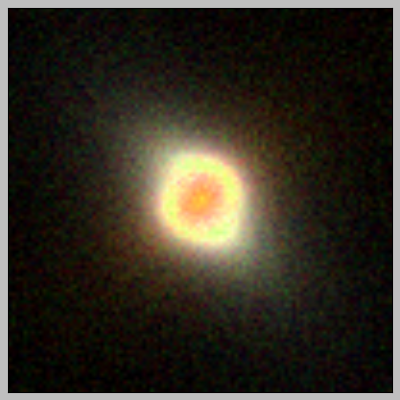

In [24]:
view_image_rgb(deeplens.CONFIGURATION_1_images[4])

and then we have the data frame

In [27]:
#we can access its columns
for col in deeplens.CONFIGURATION_1_metadata.columns:
    print(col)

OBJID-g
H0-g
Om0-g
exposure_time-g
numPix-g
pixel_scale-g
psf_type-g
read_noise-g
ccd_gain-g
seeing-g
magnitude_zero_point-g
sky_brightness-g
num_exposures-g
NUMBER_OF_NOISE_SOURCES-g
CONFIGURATION_LABEL-g
CONFIGURATION_NAME-g
NUMBER_OF_PLANES-g
PLANE_1-NUMBER_OF_OBJECTS-g
PLANE_1-OBJECT_1-NAME-g
PLANE_2-NUMBER_OF_OBJECTS-g
PLANE_2-OBJECT_1-NAME-g
PLANE_1-OBJECT_1-REDSHIFT-g
PLANE_1-OBJECT_1-NUMBER_OF_LIGHT_PROFILES-g
PLANE_1-OBJECT_1-NUMBER_OF_SHEAR_PROFILES-g
PLANE_1-OBJECT_1-NUMBER_OF_MASS_PROFILES-g
PLANE_1-OBJECT_1-HOST-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-NAME-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_x-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_y-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e1-g
PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e2-g
PLANE_1-OBJECT_1-MASS_PROFILE_1-NAME-g
PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g
PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g
PLANE_1-OBJE

In [28]:
deeplens.CONFIGURATION_1_metadata

,OBJID-g,H0-g,Om0-g,exposure_time-g,numPix-g,pixel_scale-g,psf_type-g,read_noise-g,ccd_gain-g,seeing-g,...,PLANE_1-REDSHIFT-g,PLANE_2-REDSHIFT-g,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r,PLANE_1-REDSHIFT-i,PLANE_2-REDSHIFT-i,PLANE_1-REDSHIFT-z,PLANE_2-REDSHIFT-z,PLANE_1-REDSHIFT-Y,PLANE_2-REDSHIFT-Y
0,0,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.399,...,0.622466,1.980591,0.622466,1.980591,0.622466,1.980591,0.622466,1.980591,0.622466,1.980591
2,2,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.040,...,0.726494,3.468334,0.726494,3.468334,0.726494,3.468334,0.726494,3.468334,0.726494,3.468334
3,3,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,0.982,...,0.936892,5.804329,0.936892,5.804329,0.936892,5.804329,0.936892,5.804329,0.936892,5.804329
4,4,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.559,...,0.854943,1.469482,0.854943,1.469482,0.854943,1.469482,0.854943,1.469482,0.854943,1.469482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.139,...,0.397417,3.624513,0.397417,3.624513,0.397417,3.624513,0.397417,3.624513,0.397417,3.624513
996,996,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.200,...,0.591790,2.891753,0.591790,2.891753,0.591790,2.891753,0.591790,2.891753,0.591790,2.891753
997,997,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.241,...,0.899780,4.043083,0.899780,4.043083,0.899780,4.043083,0.899780,4.043083,0.899780,4.043083
998,998,74.0,0.3,90.0,100,0.263,GAUSSIAN,7,6.083,1.139,...,0.379714,1.811365,0.379714,1.811365,0.379714,1.811365,0.379714,1.811365,0.379714,1.811365


In [29]:
#we can also search an specific  key word in the data
deeplens.search('magnitude')

{'SimulatedLens': ['CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-r',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-i',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-z',
  'CONFIGURATION_1-PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-Y'],
 'SimulatedSource': ['CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-r',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-i',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-z',
  'CONFIGURATION_1-PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-Y']}

## And the deeplens meet the DES

Those images makes me incredibly happy, the data set as a whole, cam be comparable to a real one?

<function matplotlib.pyplot.show(close=None, block=None)>

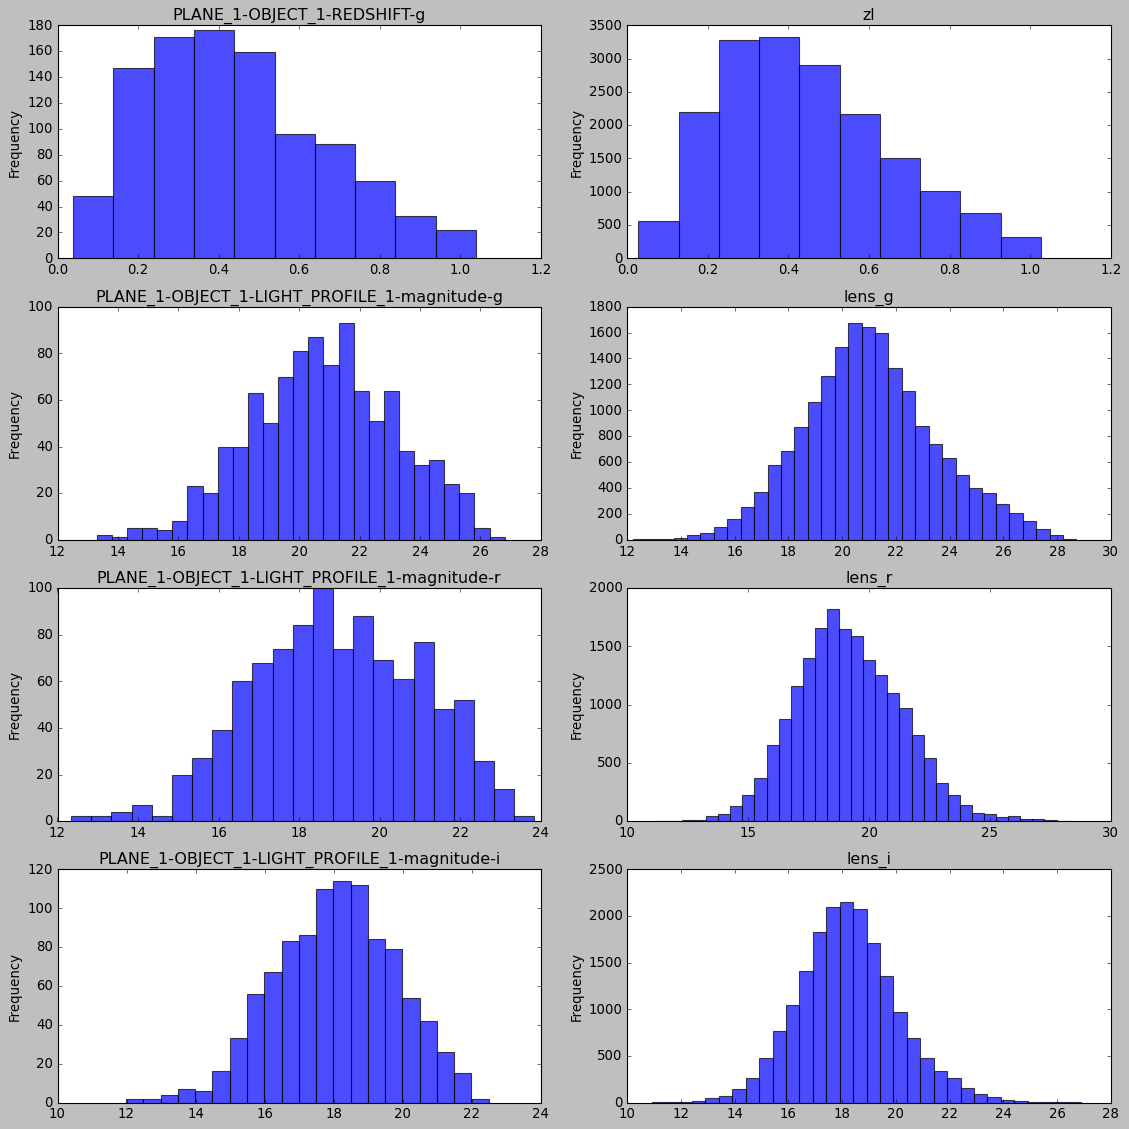

In [30]:
key_list_simulated = ["PLANE_1-OBJECT_1-REDSHIFT-g",
            'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g',
            'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-r',
            'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-i']
key_list_real =  ["zl", "lens_g", "lens_r", "lens_i"]
hor = 2
ver = 4
plt.style.use('classic')

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(ver, hor, left=0.05, right=0.5, wspace=0.05)
data = deeplens.CONFIGURATION_1_metadata
i=0
binsize=[0.1, 0.5,0.5,0.5]
def binarange(arr, binsize):
    return np.arange(np.nanmin(arr), np.nanmax(arr)+binsize, binsize)


for v in range(ver):
    #simulated data on the left
    ax = fig.add_subplot(gs[v, 0])
    bins = binarange(data[key_list_simulated[i]], binsize[i])
    ax = data[key_list_simulated[i]].plot.hist(bins=bins,  alpha=0.7)
    ax.set_title(key_list_simulated[i])
    #real data on the right
    if key_list_real[i] == "zl":
        ax = fig.add_subplot(gs[v, 1])
        bins = binarange(des[(des[key_list_real[i]] <1)][key_list_real[i]], binsize[i])
        ax = des[(des[key_list_real[i]] <1)][key_list_real[i]].plot.hist(bins=bins,  alpha=0.7)
        ax.set_title(key_list_real[i])
    else:
        ax = fig.add_subplot(gs[v, 1])
        bins = binarange(des[key_list_real[i]], binsize[i])
        ax = des[key_list_real[i]].plot.hist(bins=bins,  alpha=0.7)
        ax.set_title(key_list_real[i])
        
    
    
    i+=1
plt.show


It is worth to remember that the simulated data's histogram has a thousant points while the real data's histogram has close to 20 thousant points. even though, the simulation result approach the real one.

Simulate data will never replace observated data, but it can still offer a great help to research.